In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(18,6)})
pd.set_option('display.max_columns', None)

## Modelling

In [98]:
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.metrics import r2_score, mean_squared_error

from fbprophet import Prophet

In [100]:
DF_fut_long = pd.read_csv('E:\\Academic\\DATA & INSIGHTS\\Wheat Prices Forecasting\\stage_data\\fut_long_preprocessed.csv')
DF_fut_long['time'] = pd.to_datetime(DF_fut_long['time'])
DF_fut_long = DF_fut_long.set_index('time')

### Checking TS preperties for Model

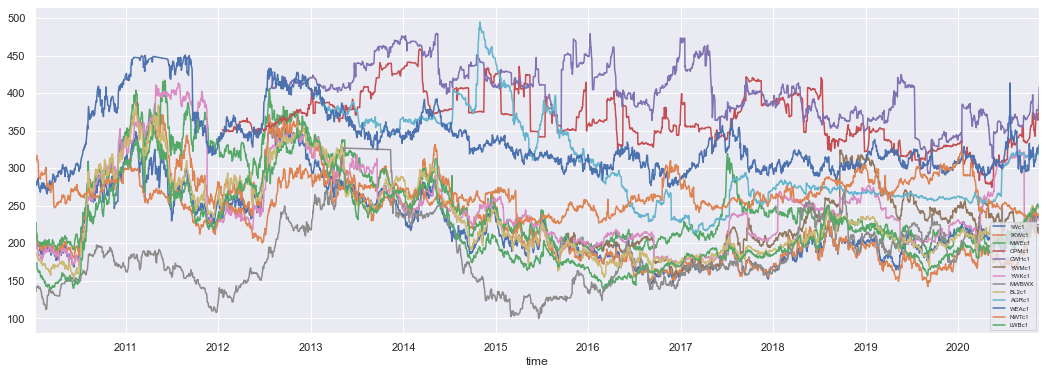

In [101]:
for i in DF_fut_long['Wheat_ID'].unique():
    (DF_fut_long.loc[DF_fut_long['Wheat_ID'] == i, 'price']).plot(label=i)
plt.legend(loc=4, prop={'size': 6})

Throw Visualisation, it can be seen that TS are mostly non-stationary

In [102]:
st_dict = {}
for i in DF_fut_long['Wheat_ID'].unique():
    adfresult = adfuller((DF_fut_long.loc[DF_fut_long['Wheat_ID'] == i,'price']).dropna(), autolag='AIC')
    kpssresult = kpss((DF_fut_long.loc[DF_fut_long['Wheat_ID'] == i,'price']).dropna(), 'ct',nlags="auto")
    st_dict[i] =[adfresult[0], adfresult[1],kpssresult[0],kpssresult[1]]

C:\Users\iti\anaconda3\envs\python3.8-sandbox\lib\site-packages\statsmodels\tsa\stattools.py:1882: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.


C:\Users\iti\anaconda3\envs\python3.8-sandbox\lib\site-packages\statsmodels\tsa\stattools.py:1882: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.


C:\Users\iti\anaconda3\envs\python3.8-sandbox\lib\site-packages\statsmodels\tsa\stattools.py:1882: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.


C:\Users\iti\anaconda3\envs\python3.8-sandbox\lib\site-packages\statsmodels\tsa\stattools.py:1882: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
lo

In [103]:
pd.DataFrame(st_dict,index=['ada_test', 'ada_p', 'kpss_test', 'kpss_p']).T

,ada_test,ada_p,kpss_test,kpss_p
1Wc1,-2.459601,0.125616,0.814058,0.01
1KWc1,-2.023741,0.276262,0.657403,0.01
MWEc1,-2.099063,0.244891,0.615126,0.01
CPMc1,-3.717109,0.003879,0.492264,0.01
CWHc1,-3.281817,0.015711,0.367556,0.01
YWMc1,-1.608194,0.479476,0.731223,0.01
YWKc1,-2.488769,0.118231,0.603102,0.01
MWBWX,-2.074101,0.255055,0.571233,0.01
BL2c1,-2.063629,0.259389,0.693350,0.01
AGRc1,-2.073764,0.255194,1.072117,0.01


The low P-Value in ADF means stationary ,while in KPSS means non-stationary <br>
By doing the ADF and KPSS tsts it can be seen that all TS are not stationary from both tests

We can try stationarize the data using many methods like (lag diff, decompsition, log, ...) <br>
From practice the log with the lag diff usually efficent and easy to reverse

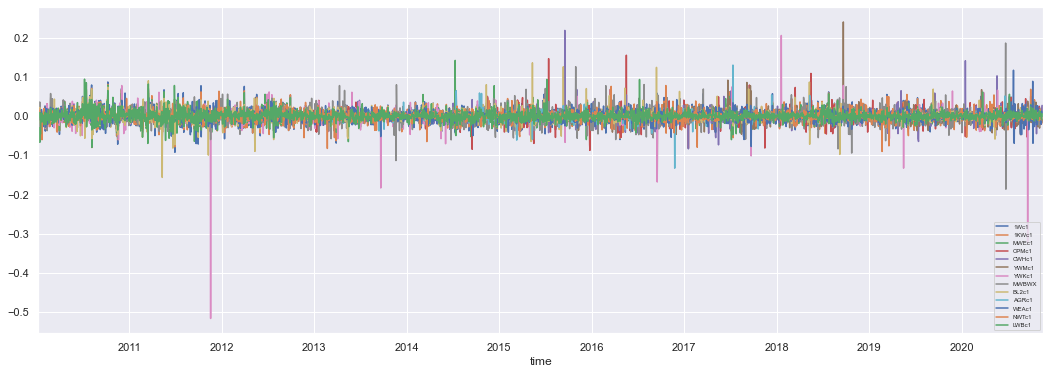

In [104]:
for i in DF_fut_long['Wheat_ID'].unique():
    np.log(DF_fut_long.loc[DF_fut_long['Wheat_ID'] == i, 'price']).diff().plot(label=i)
plt.legend(loc=4, prop={'size': 6})

In [105]:
st_dict = {}
for i in DF_fut_long['Wheat_ID'].unique():
    adfresult = adfuller(np.log(DF_fut_long.loc[DF_fut_long['Wheat_ID'] == i,'price']).diff().dropna(), autolag='AIC')
    kpssresult = kpss(np.log(DF_fut_long.loc[DF_fut_long['Wheat_ID'] == i,'price']).diff().dropna(), 'ct',nlags="auto")
    st_dict[i] =[adfresult[0], adfresult[1],kpssresult[0],kpssresult[1]]

C:\Users\iti\anaconda3\envs\python3.8-sandbox\lib\site-packages\statsmodels\tsa\stattools.py:1886: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\iti\anaconda3\envs\python3.8-sandbox\lib\site-packages\statsmodels\tsa\stattools.py:1886: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\iti\anaconda3\envs\python3.8-sandbox\lib\site-packages\statsmodels\tsa\stattools.py:1886: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\iti\anaconda3\envs\python3.8-sandbox\lib\site-packages\statsmodels\tsa\stattools.py:1886: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
lo

In [106]:
pd.DataFrame(st_dict,index=['ada_test', 'ada_p', 'kpss_test', 'kpss_p']).T

,ada_test,ada_p,kpss_test,kpss_p
1Wc1,-12.223759,1.092291e-22,0.054102,0.10000
1KWc1,-33.744152,0.000000e+00,0.072646,0.10000
MWEc1,-57.060313,0.000000e+00,0.069186,0.10000
CPMc1,-35.424183,0.000000e+00,0.031444,0.10000
CWHc1,-35.613418,0.000000e+00,0.025400,0.10000
YWMc1,-42.371057,0.000000e+00,0.088128,0.10000
YWKc1,-41.433804,0.000000e+00,0.060523,0.10000
MWBWX,-41.324910,0.000000e+00,0.075565,0.10000
BL2c1,-58.108923,0.000000e+00,0.107876,0.10000
AGRc1,-18.712065,2.034498e-30,0.071140,0.10000


After applying the lag diff with log, the TS have followed more stationary pattern with variable degree but all with very confidence.

In [107]:
DF_fut_long['price_log'] = np.log(DF_fut_long['price'])

### FBProphet

In [108]:
FB_evaluation_dict= {}
FB_model_dict={}
for i in DF_fut_long['Wheat_ID'].unique():
    ts = DF_fut_long.loc[DF_fut_long['Wheat_ID'] == i, ['price']]
    ts = ts.reset_index().rename({'time': 'ds', 'price': 'y'},axis=1)
    ts_train = ts[-1080:-60]
    ts_test = ts[-60:]
    
    model = Prophet()
    model.fit(ts_train)
    
    future = model.make_future_dataframe(periods=60)
    FB_prediction = model.predict(future)
    
    
    FB_evaluation_dict[i] = [np.sqrt(mean_squared_error(ts_test['y'], FB_prediction['yhat'][-60:])),r2_score(ts_test['y'], FB_prediction['yhat'][-60:]) ]
    FB_model_dict[i] = model
    
    print(i + " RMSE: " + str(np.sqrt(mean_squared_error(ts_test['y'], FB_prediction['yhat'][-60:]))) + " R2: " + str(r2_score(ts_test['y'], FB_prediction['yhat'][-60:])))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


1Wc1 RMSE: 21.024060195520523 R2: -3.7482498897824303


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


1KWc1 RMSE: 29.73517515667963 R2: -6.056741584594379


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MWEc1 RMSE: 6.532019341766097 R2: -0.4700682941791521


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CPMc1 RMSE: 21.876967505380108 R2: -0.9813270069359492


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CWHc1 RMSE: 19.67513736338795 R2: -2.326445249980688


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


YWMc1 RMSE: 12.774142281011189 R2: -2.1337700610039967


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


YWKc1 RMSE: 121.65292526286814 R2: -1901.0550546308932


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MWBWX RMSE: 17.836970817633453 R2: -5.652721085709032


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


BL2c1 RMSE: 10.104161865942203 R2: -0.4616728366902829


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


AGRc1 RMSE: 8.464180744238812 R2: -19.999968583492013


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


WEAc1 RMSE: 14.301002275415096 R2: -0.6765332098433892


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


NWTc1 RMSE: 4.298398644278298 R2: -4.962217449991356
LWBc1 RMSE: 6.614411437626097 R2: 0.042615809578850916


In [110]:
pd.DataFrame(FB_evaluation_dict).T.rename({0: 'RMSE', 1:'R2'},axis=1)\
#.to_csv('E:\Academic\DATA & INSIGHTS\Wheat Prices Forecasting\output_data/FB_fut_performance.csv')

,RMSE,R2
1Wc1,21.024060,-3.748250
1KWc1,29.735175,-6.056742
MWEc1,6.532019,-0.470068
CPMc1,21.876968,-0.981327
CWHc1,19.675137,-2.326445
YWMc1,12.774142,-2.133770
YWKc1,121.652925,-1901.055055
MWBWX,17.836971,-5.652721
BL2c1,10.104162,-0.461673
AGRc1,8.464181,-19.999969


In [111]:
FB_pred_dict = {}
for k, v in  FB_model_dict.items():
    future = v.make_future_dataframe(periods=150)
    FB_prediction = model.predict(future)
    FB_pred_dict[k] = FB_prediction['yhat'][-150:].values

In [112]:
 pd.DataFrame(FB_pred_dict,index=pd.date_range('2020-09-15','2021-02-11'))\
#.to_csv('E:\Academic\DATA & INSIGHTS\Wheat Prices Forecasting\output_data/FB_fut_3Month_forecasting.csv')

Visualizing predictions

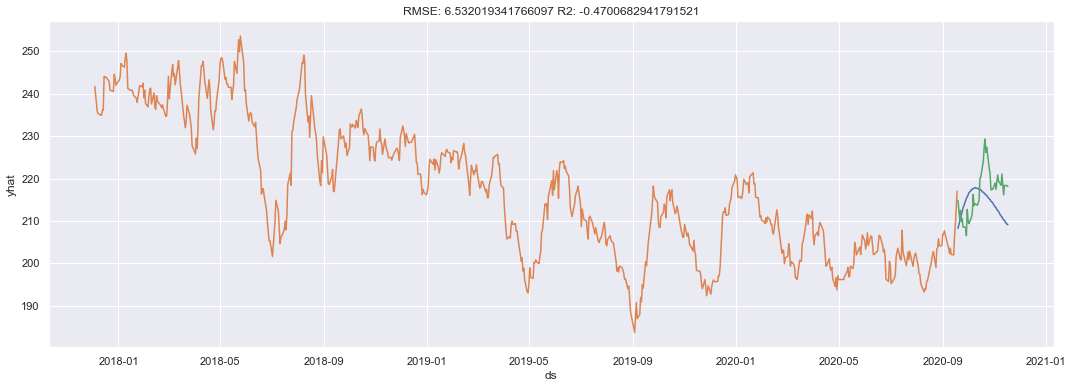

In [113]:
ts = DF_fut_long.loc[DF_fut_long['Wheat_ID'] == "MWEc1", ['price']]
ts = ts.reset_index().rename({'time': 'ds', 'price': 'y'},axis=1)
ts_train = ts[-1080:-60]
ts_test = ts[-60:]

future = FB_model_dict["MWEc1"].make_future_dataframe(periods=60)
FB_prediction = FB_model_dict["MWEc1"].predict(future)

sns.lineplot(data=FB_prediction[['ds', 'yhat']][-60:],x='ds',y='yhat')
sns.lineplot(data=ts_train.assign(ds= pd.to_datetime(ts_train['ds'])),x='ds',y='y')
sns.lineplot(data=ts_test.assign(ds= pd.to_datetime(ts_test['ds'])),x='ds',y='y' )
plt.title("RMSE: " + str(np.sqrt(mean_squared_error(ts_test['y'], FB_prediction['yhat'][-60:]))) + " R2: " + str(r2_score(ts_test['y'], FB_prediction['yhat'][-60:])))
plt.show()

FBprpophet summary:
- FBprophet is the state of the art automated time series forecasting model
- Forecasting performance on all endpoints is increased x10
- Seasonality as well as stationarity handling which required significant work on Arima took much lower time in FBprophet